In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import struct
import torch.utils.data as Data
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torchsummary import summary

myFont = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 15,
}

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,512),
            nn.ReLU(True),
            nn.Linear(512,256),
            nn.ReLU(True),
            nn.Linear(256,128),
            nn.ReLU(True),
            nn.Linear(128,64),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64,128),
            nn.ReLU(True),
            nn.Linear(128,256),
            nn.ReLU(True),
            nn.Linear(256,512),
            nn.ReLU(True),
            nn.Linear(512,784),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoder_ouput = self.encoder(x)
        decoder_output = self.decoder(encoder_ouput)
        return torch.reshape(decoder_output, (-1,1,28,28)), encoder_ouput

autoencoder = Autoencoder()
# summary(autoencoder, (1,28,28))
if torch.cuda.is_available():
    autoencoder = autoencoder.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [3]:
transform = transforms.ToTensor()

data_train = datasets.MNIST(root = "./data/",
                            transform = transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 128,
                                                shuffle = True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = 128,
                                               shuffle = True)

In [4]:
epochs = 20
loss_list = []
for epoch in range(epochs):
    for inputs, labels in data_loader_train:
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs, _ = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    print('epoch ', epoch, ' loss : ', loss.item(), sep='')

epoch 0 loss : 0.031886275857686996
epoch 1 loss : 0.024663133546710014
epoch 2 loss : 0.01971013844013214
epoch 3 loss : 0.015915682539343834
epoch 4 loss : 0.01526903547346592
epoch 5 loss : 0.013470634818077087
epoch 6 loss : 0.013265080749988556
epoch 7 loss : 0.012453274801373482
epoch 8 loss : 0.012827916070818901
epoch 9 loss : 0.010610801167786121
epoch 10 loss : 0.009887990541756153
epoch 11 loss : 0.009281017817556858
epoch 12 loss : 0.008439972065389156
epoch 13 loss : 0.008674150332808495
epoch 14 loss : 0.008436940610408783
epoch 15 loss : 0.007787225767970085
epoch 16 loss : 0.00801711343228817
epoch 17 loss : 0.0071351672522723675
epoch 18 loss : 0.007501389365643263
epoch 19 loss : 0.007404545322060585


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


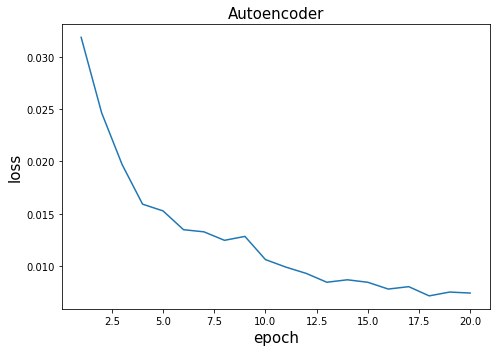

In [5]:
plt.figure(figsize=(7,5))
plt.plot(range(1,epochs+1), loss_list)
plt.xlabel('epoch', myFont)
plt.ylabel('loss', myFont)
plt.title('Autoencoder', myFont)
plt.tight_layout()
plt.show()

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
np.save('/content/drive/MyDrive/Autoencoder_losslist',loss_list)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(32,16),
            nn.ReLU(True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(32,10),
            nn.Softmax()
        )
    def forward(self, x):
        _, x = autoencoder(x)
        x = x.detach()
        x = self.fc1(x)
        x = self.fc2(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
if torch.cuda.is_available():
    net = net.cuda()

In [7]:
epochs = 10

for epoch in range(epochs):
    for inputs, labels in data_loader_train:
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch ', epoch, ' loss : ', loss.item(), sep='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch 0 loss : 1.4985474348068237
epoch 1 loss : 1.590141773223877
epoch 2 loss : 1.5104727745056152
epoch 3 loss : 1.5112401247024536
epoch 4 loss : 1.4962400197982788
epoch 5 loss : 1.4743804931640625
epoch 6 loss : 1.5148301124572754
epoch 7 loss : 1.4955247640609741
epoch 8 loss : 1.495068907737732
epoch 9 loss : 1.4959335327148438


In [8]:
total = 0
correct = 0
for inputs, labels in data_loader_test:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy of the network on test images: 96.83 %
